<div style="text-align: center; font-weight: bold; font-size: 300%">Projet INF473-V</div>                                                        <br /> 
<div style="text-align: center; font-weight: bold; font-size: 180%">Processing - ResNet-50 </div>                                                        <br />  
<div style="text-align: center; font-size: 150%">École Polytechnique, juin 2020</div><br />  
<div style="text-align: center; font-size: 120%">Youssef Allouah et Paul Calot</div>

In [0]:
# libraries
import pandas as pd # to read csv files
import numpy as np
import imageio # to read imported img
import torch
from torchvision import datasets, transforms # to transforµms to tensor etc. and create our own datasets
import matplotlib.pyplot as plt # to show img
import tqdm
from google.colab import files
import torch.nn as nn

### Link to the drive ...

https://drive.google.com/drive/folders/1xTUMQhu-JbkTSriWoLJxmJXrj5jnrKym?usp=sharing

In [8]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/projet - MODAL/datasets/"


Mounted at /content/gdrive


In [0]:
training_set = torch.load(root_dir + "dataset_8")
testing_set = torch.load(root_dir + "testing_dataset_1400")

In [0]:
# print proportion in the datasets
train_size = len(training_set)
test_size = len(testing_set)
per_train = [0,0,0,0]
per_test = [0,0,0,0]
for k in range(train_size):
  per_train[int(training_set[k][1].item())]+=1

for k in range(test_size):
  per_test[int(testing_set[k][1].item())]+=1

for k in range(4):
  per_train[k] = round(per_train[k]/train_size,4)
  per_test[k] = round(per_test[k]/test_size,4)

Size of the training dataset :5804
Size of the testing dataset :421


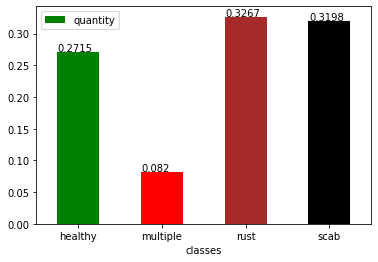

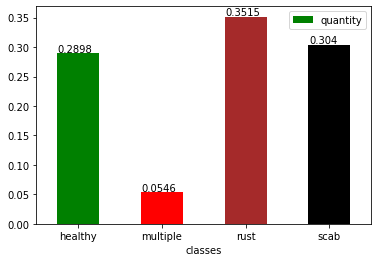

In [11]:


df = pd.DataFrame({'classes':['healthy', 'multiple', 'rust','scab'], 'quantity':per_train})
ax1 = df.plot.bar(x='classes', y='quantity', color = ['g', 'r', 'brown', 'k'], rot = 0)
fig1 = ax1.get_figure()
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x()*1.005, p.get_height() * 1.005))

df = pd.DataFrame({'classes':['healthy', 'multiple', 'rust','scab'], 'quantity':per_test})
ax2 = df.plot.bar(x='classes', y='quantity', color = ['g', 'r', 'brown', 'k'], rot = 0)
fig2 = ax2.get_figure()

for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.006))

fig1.savefig('train_repartition.png', dpi=400)
fig2.savefig('test_repartition.png', dpi=400)

print("Size of the training dataset : " + str(train_size))
print("Size of the testing dataset : " + str(test_size))


# Processing


## Importing useful functions from TDs

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

torchvision.transforms.functional.resize
transform = transforms.Compose(
    [
     transforms.Resize(size=(224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),
])



def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()




import torch.nn as nn
criterion = nn.CrossEntropyLoss()

def accuracy(net, test_loader, cuda=True):
  net.eval()
  correct = 0
  total = 0
  loss = 0
  with torch.no_grad():
      for data in test_loader:
          images, labels = data
          if cuda:
            images = images.type(torch.cuda.FloatTensor)
            labels = labels.type(torch.cuda.LongTensor)
          outputs = net(images)
          loss+= criterion(outputs, labels).item()
          _, predicted = torch.max(outputs.data, 1)
          #print(outputs, labels)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          # if total > 100:
            # break
  net.train()
  print('Accuracy of the network on the test images: %d %%' % (
      100 * correct / total))
  return (100.0 * correct / total, loss/total)
  #return 100.0 * correct/tota

def train(net, optimizer, train_loader, test_loader, loss,  n_epoch = 5,
          train_acc_period = 100,
          test_acc_period = 5,
          cuda=True):
  loss_train = []
  loss_test = []
  acc_test = []
  acc_train = []
  total = 0
  min_loss = 0
  best_state = net.state_dict()
  for epoch in tqdm.tqdm(range(n_epoch)):  # loop over the dataset multiple times
      running_loss = 0.0
      running_acc = 0.0
      for i, data in enumerate(train_loader, 0):
          # get the inputs
          inputs, labels = data
          if cuda:
            inputs = inputs.type(torch.cuda.FloatTensor)
            labels = labels.type(torch.cuda.LongTensor)
          # print(inputs.shape)
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          total += labels.size(0)
          # print statistics
          running_loss = 0.33*loss.item()/labels.size(0) + 0.66*running_loss
          _, predicted = torch.max(outputs.data, 1)
          correct = (predicted == labels).sum().item()/labels.size(0)
          running_acc = 0.3*correct + 0.66*running_acc
          if i % train_acc_period == train_acc_period-1:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss))
            print('[%d, %5d] acc: %.3f' %(epoch + 1, i + 1, running_acc))
            running_loss = 0.0
            total = 0
            # break
      if epoch % test_acc_period == test_acc_period-1:
          cur_acc, cur_loss = accuracy(net, test_loader, cuda=cuda)
          acc_test.append(cur_acc)
          loss_test.append(cur_loss)
          if(cur_loss < min_loss):
            min_loss = cur_loss
            best_state = net.state_dict()
          print('[%d] loss: %.3f' %(epoch + 1, cur_loss))
          print('[%d] acc: %.3f' %(epoch + 1, cur_acc))

          # training set
          cur_acc, cur_loss = accuracy(net, train_loader, cuda=cuda)
          acc_train.append(cur_acc)
          loss_train.append(cur_loss)
      
  print('Finished Training')
  return (loss_train, acc_train,loss_test, acc_test, min_loss, best_state)

## Confusion matrix

In [13]:
# confusion matrix
import seaborn as sn
import pandas as pd
def confusion_matrix(model, dataloader, size = 4, name = "Test", cuda = True): # here there are four classe
  model.eval()
  mat = np.zeros((size,size))
  total = 0
  corr = 0
  qty = [0]*4
  for images, labels in dataloader:
    
    if cuda:
      images = images.type(torch.cuda.FloatTensor)
      labels = labels.type(torch.cuda.LongTensor)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    for k in range(labels.size(0)): # ground truth first (row) and then prediction (col)
     # print("Here : " +str(labels[k].item()) + " ; " + str(predicted[k].item()))
      if(labels[k].item() == predicted[k].item()):
        corr +=1
      mat[labels[k].item(),predicted[k].item()]+=1
      qty[labels[k].item()]+=1
  for k in range(size):
    mat[k] *= 1/qty[k]
   # mat[k][size] = qty[k]/total # to have the total of images that the given class represented in the testing dataset
  model.train()
  dataframe = pd.DataFrame(mat, index=['healthy', 'multiple', 'rust', 'scab'])

  ax = plt.axes()

  svm = sn.heatmap(dataframe, annot=True, ax= ax)
  ax.set_title('Accuracy ' + name + " : " + str(round(corr / total,3)))
  figure = svm.get_figure()    
  figure.savefig('conf_mat' + name +'.png', dpi=400)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Plotting functions

In [0]:
# plotting results
def plot(name ,title, Y_test = None, Y_train = None, log_scale = True ):
  if(Y_test != None):
    n = len(Y_test)
    X = np.linspace(1,n,n)
    plt.plot(X,Y_test, label = "test", color = "b")
    if(Y_train != None):
      plt.plot(X,Y_train, label = "train", color = "r")
  else :
    if(Y_train != None):
      n = len(Y_train)
      X = np.linspace(1,n,n)
      plt.plot(X,Y_train, label = "train", color = "r")
    else :
      return "ERROR : both given lists are None object. "
  
  plt.legend(loc='best')
  plt.title(title)
  if(log_scale):
    plt.yscale("log")
  plt.savefig(name, dpi = 400)
  plt.show()

# Model - ResNet-50

In [15]:
model=torchvision.models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [16]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
k = 0
for child in model.children() :
  k+=1
number_of_blocs = k

In [0]:
k = 0
for param in model.parameters():
  k+=1

number_of_layers = k

In [19]:
print(" There are " + str(number_of_blocs) + " blocs in this net for a total of " + str(number_of_layers) + " layers.")

 There are 10 blocs in this net for a total of 161 layers.


In [0]:
# custom function to freeze wanted layer 
  # here 10 means that the classifier is not freeze
  
k = 0
freeze_blocs = 11 # 11 to freeze everything
for child in model.children():
  k += 1
  if(k < freeze_blocs ):
    for param in child.parameters():
      param.requires_grad = False
  else : 
    param.requires_grad = True
    print(child)
    print("was not freezed.")

In [0]:
lin = model.fc
new_lin = nn.Sequential(
    lin,
    nn.ReLU(),
    #nn.Dropout(),
    nn.Linear(lin.out_features, 4),
)

model.fc = new_lin

## Training

In [0]:
loss_train, acc_train,loss_test, acc_test = [],[],[],[]

In [0]:
model = model.cuda()
testloader = torch.utils.data.DataLoader(testing_set, 1, shuffle=False)

In [25]:
  # learning rate
lr = 3e-4

  # class weights 
class_weights = torch.FloatTensor([1, 5, 1, 1]).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)

  # optimizer
opt = torch.optim.Adam(model.parameters(),lr=lr,betas=(0.9, 0.999),eps=1e-8)

batch_size = 64
epochs = 10
testloader = torch.utils.data.DataLoader(testing_set, 1, shuffle=False)
trainloader = torch.utils.data.DataLoader(training_set, batch_size, shuffle=True)
loss_train_, acc_train_,loss_test_, acc_test_, min_loss, best_state= train(model, opt, trainloader, testloader, criterion, n_epoch = epochs, train_acc_period = 10000,
          test_acc_period = 1)

# best_state and min_loss are used to get the best state of the model afterwards



  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the network on the test images: 65 %
[1] loss: 0.928
[1] acc: 65.083


 10%|█         | 1/10 [01:26<13:02, 86.95s/it]

Accuracy of the network on the test images: 64 %
Accuracy of the network on the test images: 71 %
[2] loss: 0.783
[2] acc: 71.971


 20%|██        | 2/10 [02:53<11:35, 86.93s/it]

Accuracy of the network on the test images: 72 %
Accuracy of the network on the test images: 72 %
[3] loss: 0.768
[3] acc: 72.209


 30%|███       | 3/10 [04:20<10:08, 86.88s/it]

Accuracy of the network on the test images: 72 %
Accuracy of the network on the test images: 76 %
[4] loss: 0.666
[4] acc: 76.247


 40%|████      | 4/10 [05:47<08:41, 86.86s/it]

Accuracy of the network on the test images: 78 %
Accuracy of the network on the test images: 74 %
[5] loss: 0.665
[5] acc: 74.822


 50%|█████     | 5/10 [07:14<07:14, 86.85s/it]

Accuracy of the network on the test images: 78 %
Accuracy of the network on the test images: 76 %
[6] loss: 0.619
[6] acc: 76.010


 60%|██████    | 6/10 [08:41<05:47, 86.84s/it]

Accuracy of the network on the test images: 80 %
Accuracy of the network on the test images: 74 %
[7] loss: 0.656
[7] acc: 74.584


 70%|███████   | 7/10 [10:07<04:20, 86.81s/it]

Accuracy of the network on the test images: 79 %
Accuracy of the network on the test images: 76 %
[8] loss: 0.619
[8] acc: 76.960


 80%|████████  | 8/10 [11:34<02:53, 86.81s/it]

Accuracy of the network on the test images: 81 %
Accuracy of the network on the test images: 77 %
[9] loss: 0.611
[9] acc: 77.910


 90%|█████████ | 9/10 [13:01<01:26, 86.80s/it]

Accuracy of the network on the test images: 81 %
Accuracy of the network on the test images: 77 %
[10] loss: 0.606
[10] acc: 77.435


100%|██████████| 10/10 [14:28<00:00, 86.82s/it]

Accuracy of the network on the test images: 82 %
Finished Training


In [0]:
# saving what we got here
for k in range(len(loss_train_)):
  loss_train.append(loss_train_[k])
  acc_train.append(acc_train_[k])
  loss_test.append(loss_test_[k])
  acc_test.append(acc_test_[k])

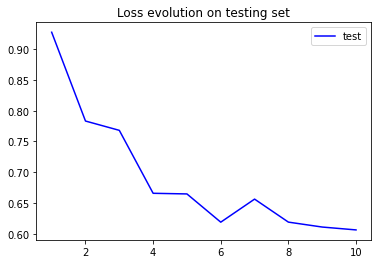

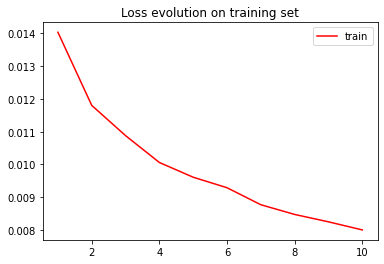

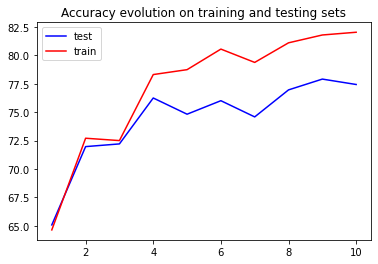

In [27]:
# Plotting results
plot("loss_test.png","Loss evolution on testing set", Y_test = loss_test, Y_train = None,  log_scale = False)
plot("loss_train.png","Loss evolution on training set", Y_test = None, Y_train = loss_train,  log_scale = False)
plot("acc_test&train.png","Accuracy evolution on training and testing sets", Y_test = acc_test, Y_train = acc_train,  log_scale = False)

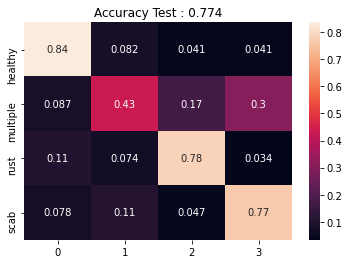

In [28]:
confusion_matrix(model, testloader)

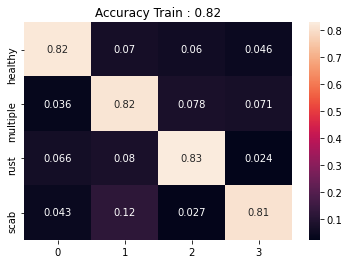

In [29]:
confusion_matrix(model, trainloader, name  = "Train")

In [0]:
torch.save(model, 'model_ResNet50_Dataset8')

# Submit model : 

In [0]:
model = torch.load("model_ResNet50_Dataset8")

In [33]:
!git clone https://gitlab.binets.fr/paul.calot-plaetevoet/plantpathology_2020.git 

Cloning into 'plantpathology_2020'...
remote: Enumerating objects: 130425, done.
remote: Counting objects: 100% (130425/130425), done.
remote: Compressing objects: 100% (130249/130249), done.
remote: Total 130425 (delta 360), reused 130239 (delta 174), pack-reused 0
Receiving objects: 100% (130425/130425), 2.01 GiB | 23.90 MiB/s, done.
Resolving deltas: 100% (360/360), done.
Checking out files: 100% (33570/33570), done.


In [0]:
path = "plantpathology_2020/commit_images_resized/Test_"

In [0]:
images = []
for k in range(1821):
    path_img_training_k = path + str(k) + ".jpg"
    img = imageio.imread(path_img_training_k)
    img =  img.astype(np.float32)/255.0
    images.append(np.transpose(img, (2,0,1))) # may work better

images = torch.Tensor(images) # submit images - 1821


In [0]:
# model should be in cuda
L=[]
for k in range(1821):
  L.append(model(images[k].unsqueeze(0).cuda()))

M=[]
for k in range(len(L)):
  M.append(nn.Softmax(dim=1)(L[k].cpu().data))

new_csv = [["image_id", "healthy","multiple_diseases","rust","scab"]] # always like this
for k in range(1821):
  l = ["Test_"+str(1821)]
  t = M[k][0].numpy()
  for j in range(4):
    l.append(t[j])
  new_csv.append(l)

import csv

with open("submit.csv","w") as outfile:
    out = csv.writer(outfile,delimiter=',')
    for row in new_csv:
        out.writerow(row)